In [1]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import gzip
import json
from matplotlib import pyplot as plt

def load_jsonlines_to_df(file_path):
    """
    Loads a gzipped JSON Lines file into a Pandas DataFrame,
    processes the 'accession_type' to ensure it's a single string label,
    balances the dataset by sampling up to 10000 instances per class,
    and selects only the specified columns.

    :param file_path: Path to the .jsonl.gz file.
    :return: A balanced Pandas DataFrame with selected columns and a LabelEncoder.
    """
    with gzip.open(file_path, 'rt', encoding='utf-8') as gzfile:
        data = [json.loads(line) for line in gzfile]
    
    columns_to_keep = ['abstract', 'accession_type']
    
    # Create DataFrame
    df = pd.DataFrame(data)
    df = df[columns_to_keep]
    
    # Ensure 'accession_type' exists
    if 'accession_type' not in df.columns:
        raise KeyError("Column 'accession_type' not found in the dataset.")
    
    # Process 'accession_type' to ensure it's a single string
    df['accession_type'] = df['accession_type'].apply(
        lambda labels: 'metagenomics' if 'metagenomics' in labels else 'other'
    )
    
    # Encode 'accession_type' into 'label'
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['accession_type'])
    
#     # Balance the dataset: sample up to 10000 instances per class
#     df_balanced = df.groupby('accession_type').apply(
#         lambda x: x.sample(n=min(500, len(x)), random_state=0)
#     ).reset_index(drop=True)

    df_balanced = df.copy()
    # Diagnostic Checks
    print(f"Loaded DataFrame shape: {df_balanced.shape}")
    print("Label distribution after balancing:")
    print(df_balanced['accession_type'].value_counts())
    print("\nSample data:")
    print(df_balanced.head())
    
    df_balanced.rename(columns={'accession_type': 'class_label'}, inplace=True)
    return df_balanced, label_encoder

# File paths
file_path = '/nfs/production/literature/santosh_tirunagari/BACKUP/work/github/metagenomics/notebooks/final_multi_label_trainingset.jsonl.gz'

data, label_encoder = load_jsonlines_to_df(file_path)
# Sample size
# n = 10000  # Set your desired sample size
# 
data
# 
# data

Loaded DataFrame shape: (219802, 3)
Label distribution after balancing:
accession_type
other           210302
metagenomics      9500
Name: count, dtype: int64

Sample data:
                                            abstract accession_type  label
0  Down-regulation of the Drosophila ribosomal pr...          other      1
1  Human chromosomal region 1q24 encodes two clon...          other      1
2  A bovine plasminogen activator was purified fr...          other      1
3  Staphylococcus aureus and Staphylococcus epide...          other      1
4  Kinetic analysis of two mutations within Pseud...          other      1


,abstract,class_label,label
0,Down-regulation of the Drosophila ribosomal pr...,other,1
1,Human chromosomal region 1q24 encodes two clon...,other,1
2,A bovine plasminogen activator was purified fr...,other,1
3,Staphylococcus aureus and Staphylococcus epide...,other,1
4,Kinetic analysis of two mutations within Pseud...,other,1
...,...,...,...
219797,Kaposi's sarcoma-associated herpesvirus (KSHV)...,other,1
219798,The pathway of autotrophic CO2 fixation was st...,other,1
219799,The mannose-sensitive hemagglutinin (MSHA) of ...,other,1
219800,Pseudomonas putida GJ31 contains an unusual ca...,other,1


In [2]:
import torch

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [3]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element: token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Compute embeddings for a list of sentences
def compute_embeddings(sentences, batch_size=32):
    model.eval()  # Set model to evaluation mode
    sentence_embeddings = []

    for i in tqdm(range(0, len(sentences), batch_size), desc="Processing Batches"):
        # Process a batch of sentences
        batch = sentences[i:i + batch_size]
        encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(device)
        
        with torch.no_grad():
            model_output = model(**encoded_input)
        
        # Mean pooling to get sentence embeddings
        batch_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        
        # Normalize embeddings
        batch_embeddings = F.normalize(batch_embeddings, p=2, dim=1)
        sentence_embeddings.extend(batch_embeddings.cpu().numpy())  # Move to CPU and convert to NumPy arrays
    
    return sentence_embeddings

# # Example usage
# sentences = ["This is a test sentence.", "Here is another one."]
# embeddings = compute_embeddings(sentences)
# print(f"Computed {len(embeddings)} embeddings of dimension {embeddings[0].shape}")



/nfs/production/literature/santosh_tirunagari/transformers_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/nfs/production/literature/santosh_tirunagari/transformers_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/nfs/production/literature/santosh_tirunagari/transformers_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
sentences = data['abstract'].tolist()
embeddings = compute_embeddings(sentences, batch_size=64)  # Adjust batch size as needed

# Assign embeddings to the DataFrame
data['embeddings'] = embeddings  # Each row gets a 1D array (shape: (768,))



Processing Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████| 3435/3435 [06:47<00:00,  8.42it/s]


In [5]:
import os
import pandas as pd

def load_abstracts_from_folders(folder_1_path, folder_2_path):
    """
    Loads abstracts from two folders into a pandas DataFrame.

    Parameters:
        folder_1_path (str): Path to the folder containing metagenomics abstracts.
        folder_2_path (str): Path to the folder containing other abstracts.

    Returns:
        pd.DataFrame: A DataFrame containing abstracts and their class labels.
    """
    abstracts = []
    class_labels = []

    # Load abstracts from folder_1 (metagenomics)
    for file_name in os.listdir(folder_1_path):
        file_path = os.path.join(folder_1_path, file_name)
        if os.path.isfile(file_path) and file_name.endswith('.txt'):
            with open(file_path, 'r', encoding='utf-8') as file:
                abstracts.append(file.read())
                class_labels.append('metagenomics')

    # Load abstracts from folder_2 (other)
    for file_name in os.listdir(folder_2_path):
        file_path = os.path.join(folder_2_path, file_name)
        if os.path.isfile(file_path) and file_name.endswith('.txt'):
            with open(file_path, 'r', encoding='utf-8') as file:
                abstracts.append(file.read())
                class_labels.append('other')

    # Create DataFrame
    data = pd.DataFrame({
        'abstract': abstracts,
        'class_label': class_labels
    })

    return data

# Paths to folders
folder_1_path = "/nfs/production/literature/santosh_tirunagari/mgnify_abstracts/txt/abs/"  # Update with the actual path to folder_1
folder_2_path = "/nfs/production/literature/santosh_tirunagari/txt/abs"  # Update with the actual path to folder_2

# Load abstracts into a DataFrame
data_met = load_abstracts_from_folders(folder_1_path, folder_2_path)

# Check the structure of the DataFrame
print(data_met.head())
print(f"Total abstracts: {data_met.shape[0]}")


                                            abstract   class_label
0  In the Zambales ophiolite range, terrestrial s...  metagenomics
1  Understanding environment-community relationsh...  metagenomics
2  Dental caries is a highly prevalent oral disea...  metagenomics
3  Seafloor sediments cover the majority of plane...  metagenomics
4  Previous studies have reported that gut microb...  metagenomics
Total abstracts: 2180


In [7]:
met_sentences = data_met['abstract'].tolist()
met_embeddings = compute_embeddings(met_sentences, batch_size=32)  # Adjust batch size as needed

# Assign embeddings to the DataFrame
data_met['embeddings'] = met_embeddings  # Each row gets a 1D array (shape: (768,))



Processing Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:04<00:00, 15.66it/s]


In [8]:
from sklearn.cluster import KMeans
import numpy as np

# Extract embeddings from the `data_met` DataFrame
metagenomics_embeddings = np.stack(data_met['embeddings'].values)

# Apply K-Means to create centroids for metagenomics
n_clusters_metagenomics = 20  # Choose an appropriate number of clusters
kmeans_metagenomics = KMeans(n_clusters=n_clusters_metagenomics, random_state=42)
kmeans_metagenomics.fit(metagenomics_embeddings)

# Centroids for metagenomics
metagenomics_centroids = kmeans_metagenomics.cluster_centers_
print(f"Metagenomics centroids shape: {metagenomics_centroids.shape}")


/nfs/production/literature/santosh_tirunagari/transformers_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Metagenomics centroids shape: (20, 384)


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

tqdm.pandas(desc="Computing Similarity Scores")

# Compute maximum similarity to metagenomics centroids
data['similarity_to_metagenomics'] = data['embeddings'].progress_apply(
    lambda x: cosine_similarity([x], metagenomics_centroids).max(axis=1)[0]
)


Computing Similarity Scores: 100%|████████████████████████████████████████████████████████████████████████| 219802/219802 [01:08<00:00, 3221.25it/s]


In [36]:
# Define thresholds
threshold_metagenomics = 0.7
threshold_other = 0.4

# Classify samples based on similarity scores
data['predicted_class'] = 'overlap'  # Default category
data.loc[data['similarity_to_metagenomics'] >= threshold_metagenomics, 'predicted_class'] = 'metagenomics'
data.loc[data['similarity_to_metagenomics'] <= threshold_other, 'predicted_class'] = 'other'

# Filter datasets
filtered_metagenomics = data[data['predicted_class'] == 'metagenomics']
filtered_other = data[data['predicted_class'] == 'other']
overlapping_samples = data[data['predicted_class'] == 'overlap']

print(f"Metagenomics Samples: {len(filtered_metagenomics)}")
print(f"Other Samples: {len(filtered_other)}")
print(f"Overlapping Samples: {len(overlapping_samples)}")


Metagenomics Samples: 6498
Other Samples: 115248
Overlapping Samples: 98056


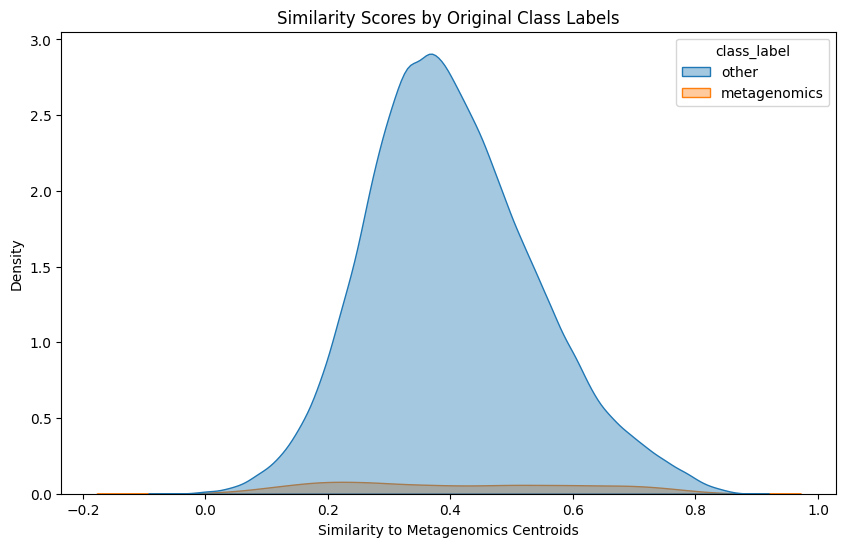

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# KDE plot of similarity scores by original and predicted classes
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='similarity_to_metagenomics', hue='class_label', fill=True, alpha=0.4)
plt.title('Similarity Scores by Original Class Labels')
plt.xlabel('Similarity to Metagenomics Centroids')
plt.ylabel('Density')
plt.show()


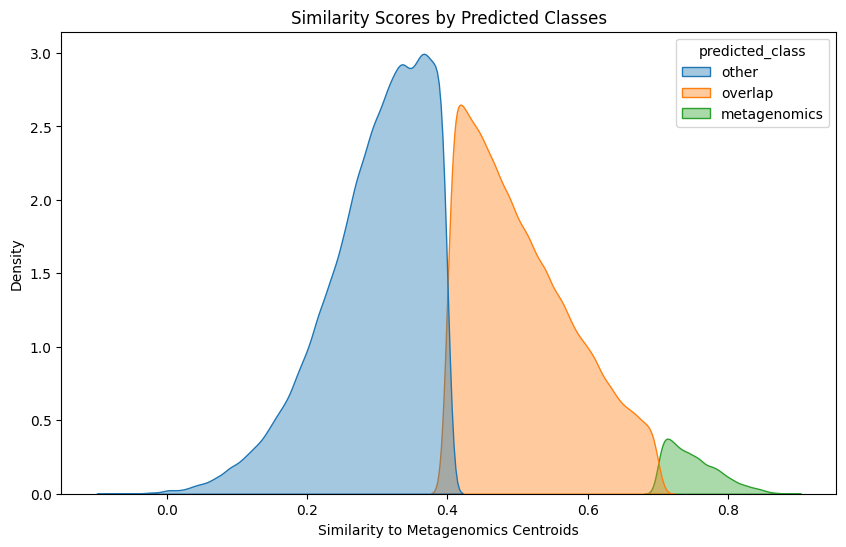

In [38]:
# KDE plot for predicted classes
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='similarity_to_metagenomics', hue='predicted_class', fill=True, alpha=0.4)
plt.title('Similarity Scores by Predicted Classes')
plt.xlabel('Similarity to Metagenomics Centroids')
plt.ylabel('Density')
plt.show()

In [39]:
# Compare the original and predicted labels
comparison = data.groupby(['class_label', 'predicted_class']).size().reset_index(name='count')
print(comparison)


    class_label predicted_class   count
0  metagenomics    metagenomics     934
1  metagenomics           other    4870
2  metagenomics         overlap    3696
3         other    metagenomics    5564
4         other           other  110378
5         other         overlap   94360


In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Combine filtered datasets
filtered_data = pd.concat([filtered_metagenomics, filtered_other], ignore_index=True)

# Use LabelEncoder to encode the predicted class
label_encoder = LabelEncoder()
filtered_data['class_label'] = label_encoder.fit_transform(filtered_data['predicted_class'])


# Convert embeddings to a NumPy array
X = np.stack(filtered_data['embeddings'].values)  # Features
y = filtered_data['class_label'].values                 # Labels


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Class distribution in training set: {np.bincount(y_train)}")
print(f"Class distribution in testing set: {np.bincount(y_test)}")

Training set size: 97396
Testing set size: 24350
Class distribution in training set: [ 5198 92198]
Class distribution in testing set: [ 1300 23050]


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train the Logistic Regression classifier
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

metagenomics       0.99      1.00      1.00      1300
       other       1.00      1.00      1.00     23050

    accuracy                           1.00     24350
   macro avg       1.00      1.00      1.00     24350
weighted avg       1.00      1.00      1.00     24350



In [17]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

metagenomics       1.00      0.99      1.00       557
       other       1.00      1.00      1.00     10393

    accuracy                           1.00     10950
   macro avg       1.00      1.00      1.00     10950
weighted avg       1.00      1.00      1.00     10950



In [42]:
import os
import pickle
from transformers import AutoModel, AutoTokenizer

# Define the base folder path to save artifacts
base_path = "/nfs/production/literature/santosh_tirunagari/metagenomics_ner_model_training"
os.makedirs(base_path, exist_ok=True)

# Create separate folders for each artifact type
model_folder = os.path.join(base_path, "hf_model")
tokenizer_folder = os.path.join(base_path, "hf_tokenizer")
label_encoder_folder = os.path.join(base_path, "label_encoder")
logreg_folder = os.path.join(base_path, "logistic_regression")

os.makedirs(model_folder, exist_ok=True)
os.makedirs(tokenizer_folder, exist_ok=True)
os.makedirs(label_encoder_folder, exist_ok=True)
os.makedirs(logreg_folder, exist_ok=True)

# Save the Hugging Face model and tokenizer
model_name = 'all-MiniLM-L6-v2'  # Replace with your model name
model.save_pretrained(model_folder)
tokenizer.save_pretrained(tokenizer_folder)

# Save the LabelEncoder
label_encoder_path = os.path.join(label_encoder_folder, "label_encoder.pkl")
with open(label_encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)

# Save the Logistic Regression classifier
logreg_path = os.path.join(logreg_folder, "logistic_regression.pkl")
with open(logreg_path, 'wb') as f:
    pickle.dump(clf, f)

print("Artifacts saved in separate folders:")
print(f"Hugging Face Model: {model_folder}")
print(f"Hugging Face Tokenizer: {tokenizer_folder}")
print(f"Label Encoder: {label_encoder_folder}")
print(f"Logistic Regression Classifier: {logreg_folder}")


Artifacts saved in separate folders:
Hugging Face Model: /nfs/production/literature/santosh_tirunagari/metagenomics_ner_model_training/hf_model
Hugging Face Tokenizer: /nfs/production/literature/santosh_tirunagari/metagenomics_ner_model_training/hf_tokenizer
Label Encoder: /nfs/production/literature/santosh_tirunagari/metagenomics_ner_model_training/label_encoder
Logistic Regression Classifier: /nfs/production/literature/santosh_tirunagari/metagenomics_ner_model_training/logistic_regression


In [43]:
import pickle
from transformers import AutoModel, AutoTokenizer
import torch.nn.functional as F
import torch

# Global variables for models and artifacts
model = None
tokenizer = None
label_encoder = None
clf = None

# Load all models and artifacts once
def load_artifacts(base_path):
    """
    Load all necessary models and artifacts into memory.

    Args:
        base_path (str): Path to the folder containing saved models and artifacts.
    """
    global model, tokenizer, label_encoder, clf

    # Paths to each folder
    model_folder = os.path.join(base_path, "hf_model")
    tokenizer_folder = os.path.join(base_path, "hf_tokenizer")
    label_encoder_path = os.path.join(base_path, "label_encoder", "label_encoder.pkl")
    logreg_path = os.path.join(base_path, "logistic_regression", "logistic_regression.pkl")

    # Load Hugging Face model and tokenizer
    model = AutoModel.from_pretrained(model_folder)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)

    # Load LabelEncoder
    with open(label_encoder_path, 'rb') as f:
        label_encoder = pickle.load(f)

    # Load Logistic Regression classifier
    with open(logreg_path, 'rb') as f:
        clf = pickle.load(f)

    print("Artifacts loaded successfully.")


In [44]:
base_path = "/nfs/production/literature/santosh_tirunagari/metagenomics_ner_model_training"
load_artifacts(base_path)


Artifacts loaded successfully.


In [45]:
def mean_pooling(model_output, attention_mask):
    """
    Mean pooling function that takes attention masks into account.
    """
    token_embeddings = model_output[0]  # First element: token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def classify_abstract(abstract):
    """
    Classifies an abstract using preloaded models and artifacts.

    Args:
        abstract (str): The abstract to classify.

    Returns:
        dict: A dictionary with predicted class label and probabilities.
    """
    global model, tokenizer, label_encoder, clf

    # Ensure models and artifacts are loaded
    if model is None or tokenizer is None or label_encoder is None or clf is None:
        raise RuntimeError("Artifacts are not loaded. Please call `load_artifacts` first.")

    # Process the input abstract
    model.eval()  # Ensure the model is in evaluation mode
    encoded_input = tokenizer(abstract, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    sentence_embedding = F.normalize(sentence_embedding, p=2, dim=1).cpu().numpy()

    # Predict the class label and probability
    predicted_probabilities = clf.predict_proba(sentence_embedding)[0]
    predicted_label = clf.predict(sentence_embedding)[0]
    class_label = label_encoder.inverse_transform([predicted_label])[0]

    # Return the results
    return {
        "predicted_class_label": class_label,
        "predicted_probabilities": predicted_probabilities
    }


In [50]:
abstract_1 = '''
Objective
Hypoglycemia is a major concern in type 2 diabetes (T2DM), but little is known about its likelihood compared across common therapies. We compared the likelihood of hypoglycemia among metformin-treated patients with T2DM randomized to the addition of one of 4 common therapies.
Research design & methods
Randomized, controlled trial of 5,047 participants with T2DM of <10 years' duration, hemoglobin A1c (HbA1c) 6.8-8.5% (50.8-69.4 mmol/mol). Randomization to addition of glargine U100, glimepiride, liraglutide, or sitagliptin over 5.0 ± 1.3 (mean ± SD) years. HbA1c was measured quarterly; if a level >7.5% (>58.5 mmol/mol) was confirmed, rescue glargine and/or aspart insulin was added. We conducted a per-protocol analysis of 4,830, who attended at least one post-baseline visit and took at least one dose of assigned study medication. We assessed severe hypoglycemia events reported throughout the entire study. At quarterly visits, all participants were asked about hypoglycemic symptoms within the last 30 days, and those in the glargine and glimepiride groups were asked for any measured glucose <70 mg/dL (3.9 mmol/L) within this time period.
Results
While participants were taking their assigned medications, severe hypoglycemia occurred in 10 (0.8%), 16 (1.3%), 6 (0.5%), and 4 (0.3%), (p<0.05) and hypoglycemic symptoms in 659 (54.2%), 833 (68.3%), 375 (32.4%), and 361 (29.1%) of participants following randomization to glargine, glimepiride, liraglutide, and sitagliptin, respectively (p<0.001).
Conclusions
In metformin-treated patients with T2DM who add a second medication, hypoglycemia is most likely with addition of glimepiride, less with glargine, and least likely with liraglutide and sitagliptin.

'''


print(classify_abstract(abstract_1))


{'predicted_class_label': 'other', 'predicted_probabilities': array([4.81090622e-04, 9.99518909e-01])}
